In [176]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import json
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import GOSTnets as gn
import numpy as np
import datetime
import logging

import itertools
from multiprocessing import Pool, cpu_count
import multiprocessing

In [9]:
!ls data

GrafoLima_edges.csv	 GrafoLima_edgeswaze.zip  GrafoLima_nodes.zip
GrafoLima_edgeswaze.csv  GrafoLima_nodes.csv


In [4]:
##Logger
logging.root.handlers.clear()
logging.root.handlers

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
log_filename = f"logs/CuscoEdgesWaze1400_{timestamp}.log"

# logging.basicConfig(
#     level=logging.INFO,
#     datefmt='%Y-%m-%d %H:%M:%S',
# )

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logFormatter = logging.Formatter('%(asctime)s :: %(levelname)s :: %(name)s :: %(process)d :: %(message)s')

# fileHandler = logging.FileHandler(log_filename)
# fileHandler.setFormatter(logFormatter)
# logger.addHandler(fileHandler)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(logFormatter)
logger.addHandler(streamHandler)
##Logger

In [25]:
%%time
transporte_nodes = pd.read_csv("../SimBig22/rutas/GrafoTransporte_nodes.csv")
gs = gpd.GeoSeries.from_wkt(transporte_nodes['geometry'])
transporte_nodes = gpd.GeoDataFrame(transporte_nodes, geometry=gs).set_index('osmid')
logger.info("Loading Transporte_nodes")
transporte_nodes.head()


2023-09-03 16:31:40,068 :: INFO :: root :: 13539 :: Loading Transporte_nodes


CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 110 ms


,y,x,street_count,highway,ref,geometry
osmid,,,,,,
1746796546,-12.044960,-76.979237,4,NaN,NaN,POINT (-76.97924 -12.04496)
4284776453,-12.200702,-77.019886,4,NaN,NaN,POINT (-77.01989 -12.20070)
4200497160,-12.062238,-77.094624,3,NaN,NaN,POINT (-77.09462 -12.06224)
5497389066,-12.023795,-76.809376,3,NaN,NaN,POINT (-76.80938 -12.02379)
1746796556,-12.045230,-76.974936,4,NaN,NaN,POINT (-76.97494 -12.04523)


# Grafo Transporte de Lima

In [6]:
# G = ox.load_graphml('../SimBig22/rutas/GrafoTransporte.graphml')
# G_nodes, G_edges = ox.graph_to_gdfs(G)
# # nx.get_edge_attributes(G2, 'w3')
# print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 14207
Number of edges: 17930
Average in degree:   1.2621
Average out degree:   1.2621


In [10]:
nodes = pd.read_csv("data/GrafoLima_nodes.csv", index_col=[0])
nodes['geometry'] = nodes['geometry'].apply(wkt.loads)
nodes = gpd.GeoDataFrame(nodes, crs='epsg:4326')

In [11]:
nodes.head()

,y,x,ref,highway,street_count,geometry
osmid,,,,,,
258066779,-12.371360,-76.784678,45A,motorway_junction,3,POINT (-76.78468 -12.37136)
258066780,-12.376318,-76.779559,NaN,NaN,3,POINT (-76.77956 -12.37632)
258066781,-12.384553,-76.771046,NaN,NaN,3,POINT (-76.77105 -12.38455)
258066783,-12.385783,-76.769768,NaN,NaN,3,POINT (-76.76977 -12.38578)
258067237,-12.304254,-76.840727,NaN,NaN,3,POINT (-76.84073 -12.30425)


In [12]:
edges = pd.read_csv("data/GrafoLima_edgeswaze.csv", index_col=[0,1,2])
edges['geometry'] = edges['geometry'].apply(wkt.loads)
edges = gpd.GeoDataFrame(edges, crs='epsg:4326')

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5,7,13,14,15,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
cols = ['wazeinfo0800_minutes', 'wazeinfo0800_km', 'wazeinfo1400_minutes', 'wazeinfo1400_km']
edges.loc[ :, cols] = edges[cols].replace({-1:np.nan})

In [18]:
edges.head()

osmid  oneway lanes  \
u         v           key                                                     
258066779 10985400003 0                              39457621    True     1   
          258066780   0    [1046533254, 338193454, 143630423]    True     2   
258066780 258066781   0                             143630430    True     2   
258066781 258066783   0                             143630430    True     2   
          495302399   0                              40752940    True     1   

                                 highway maxspeed    length  \
u         v           key                                     
258066779 10985400003 0    motorway_link       80   109.492   
          258066780   0         motorway      100   782.922   
258066780 258066781   0            trunk      100  1301.315   
258066781 258066783   0            trunk      100   194.871   
          495302399   0       trunk_link      NaN    85.154   

                                                                    geometry  \
u         v           key                                                      
258066779 10985400003 0    LINESTRING (-76.78468 -12.37136, -76.78466 -12...   
          258066780   0    LINESTRING (-76.78468 -12.37136, -76.78433 -12...   
258066780 258066781   0    LINESTRING (-76.77956 -12.37632, -76.77670 -12...   
258066781 258066783   0    LINESTRING (-76.77105 -12.38455, -76.76977 -12...   
          495302399   0    LINESTRING (-76.77105 -12.38455, -76.77099 -12...   

                             ref                        name bridge  ...  \
u         v           key                                            ...   
258066779 10985400003 0      NaN                         NaN    NaN  ...   
          258066780   0    PE-1S  Carretera Panamericana Sur    yes  ...   
258066780 258066781   0    PE-1S  Carretera Panamericana Sur    NaN  ...   
258066781 258066783   0    PE-1S  Carretera Panamericana Sur    NaN  ...   
          495302399   0      NaN                         NaN    NaN  ...   

                          access tunnel width  service  \
u         v           key                                
258066779 10985400003 0      NaN    NaN   NaN      NaN   
          258066780   0      NaN    NaN   NaN      NaN   
258066780 258066781   0      NaN    NaN   NaN      NaN   
258066781 258066783   0      NaN    NaN   NaN      NaN   
          495302399   0      NaN    NaN   NaN      NaN   

                                           wazeinfo0800  \
u         v           key                                 
258066779 10985400003 0                   (0.05, 0.107)   
          258066780   0                   (0.45, 0.781)   
258066780 258066781   0    (0.03333333333333333, 0.063)   
258066781 258066783   0     (1.6666666666666667, 0.612)   
          495302399   0                    (0.1, 0.091)   

                                           wazeinfo1400 wazeinfo0800_minutes  \
u         v           key                                                      
258066779 10985400003 0                   (0.05, 0.107)             0.050000   
          258066780   0                   (0.45, 0.781)             0.450000   
258066780 258066781   0    (0.03333333333333333, 0.063)             0.033333   
258066781 258066783   0     (1.7166666666666666, 0.612)             1.666667   
          495302399   0                    (0.1, 0.091)             0.100000   

                           wazeinfo0800_km  wazeinfo1400_minutes  \
u         v           key                                          
258066779 10985400003 0              0.107              0.050000   
          258066780   0              0.781              0.450000   
258066780 258066781   0              0.063              0.033333   
258066781 258066783   0              0.612              1.716667   
          495302399   0              0.091              0.100000   

                           wazeinfo1400_km  
u         v           key                   
258066779 1098540

In [24]:
G = ox.graph_from_gdfs(nodes, edges)
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 148111
Number of edges: 395620
Average in degree:   2.6711
Average out degree:   2.6711


In [115]:
nx.is_directed(G)

True

In [119]:
G2 = G.to_undirected()

In [120]:
print(nx.info(G2))

Name: 
Type: MultiGraph
Number of nodes: 148111
Number of edges: 222783
Average degree:   3.0083


## SubGrafo de Transporte Lima

In [121]:
H = G2.subgraph(list(transporte_nodes.index)).copy()
print(nx.info(H))

Name: 
Type: MultiGraph
Number of nodes: 13498
Number of edges: 12222
Average degree:   1.8109


In [122]:
H_isolates = list(nx.isolates(H))
H_isolates

[5497389066,
 1482227739,
 3993075744,
 1482227757,
 1273692402,
 133955870,
 4343202104,
 4336189865,
 4336189866,
 442761704,
 1814004295,
 1573127009,
 1426686852,
 1426686853,
 3738207217,
 1756333293,
 4343596321,
 5022483752,
 4343596333,
 1573127501,
 4351296886,
 4347725401,
 5022418641,
 5079893768,
 5947000837,
 5192190223,
 632031544,
 4271868222,
 9258371504,
 289311528,
 7092603925,
 371264698,
 4972318020,
 679644542,
 679644582,
 914296525,
 5762617127,
 289312567,
 1278938940,
 262574003,
 1273696200,
 1723437044,
 1024462915,
 4741599338,
 4741599346,
 4741599362,
 4741599372,
 4741599408,
 1305383151,
 4741599522,
 1670123996,
 847516220,
 4042232534,
 5057188612,
 3272086463,
 5452502064,
 31036685,
 5413147921,
 7577212193,
 4286256490,
 859739642,
 1354143288,
 846730933,
 4272035805,
 430020642,
 430020646,
 4276394124,
 915282101,
 4341864680,
 4386888016,
 1468897673,
 915282358,
 1412831734,
 8213863118,
 821664660,
 5027405046,
 1577491932,
 1577492069,
 17576

In [123]:
print("Number of nodes: %s" % H.number_of_nodes())
print("Number of isolates %s" % nx.number_of_isolates(H))

print("Ratio of isolates %.3f" % (nx.number_of_isolates(H) / H.number_of_nodes()) )

Number of nodes: 13498
Number of isolates 375
Ratio of isolates 0.028


In [124]:
H.remove_nodes_from(H_isolates)

In [125]:
print(nx.info(H))
nx.number_of_isolates(H)

Name: 
Type: MultiGraph
Number of nodes: 13123
Number of edges: 12222
Average degree:   1.8627


0

In [127]:
H_nodes, H_edges = ox.graph_to_gdfs(H)

In [128]:
H_nodes.head()

,y,x,street_count,geometry,highway,ref
osmid,,,,,,
1746796546,-12.044960,-76.979237,4,POINT (-76.97924 -12.04496),NaN,NaN
4284776453,-12.200702,-77.019886,4,POINT (-77.01989 -12.20070),NaN,NaN
4200497160,-12.062235,-77.094626,3,POINT (-77.09463 -12.06223),NaN,NaN
1746796556,-12.045230,-76.974936,4,POINT (-76.97494 -12.04523),NaN,NaN
4335599630,-12.119051,-77.027579,3,POINT (-77.02758 -12.11905),NaN,NaN


In [129]:
H_nodes.shape

(13123, 6)

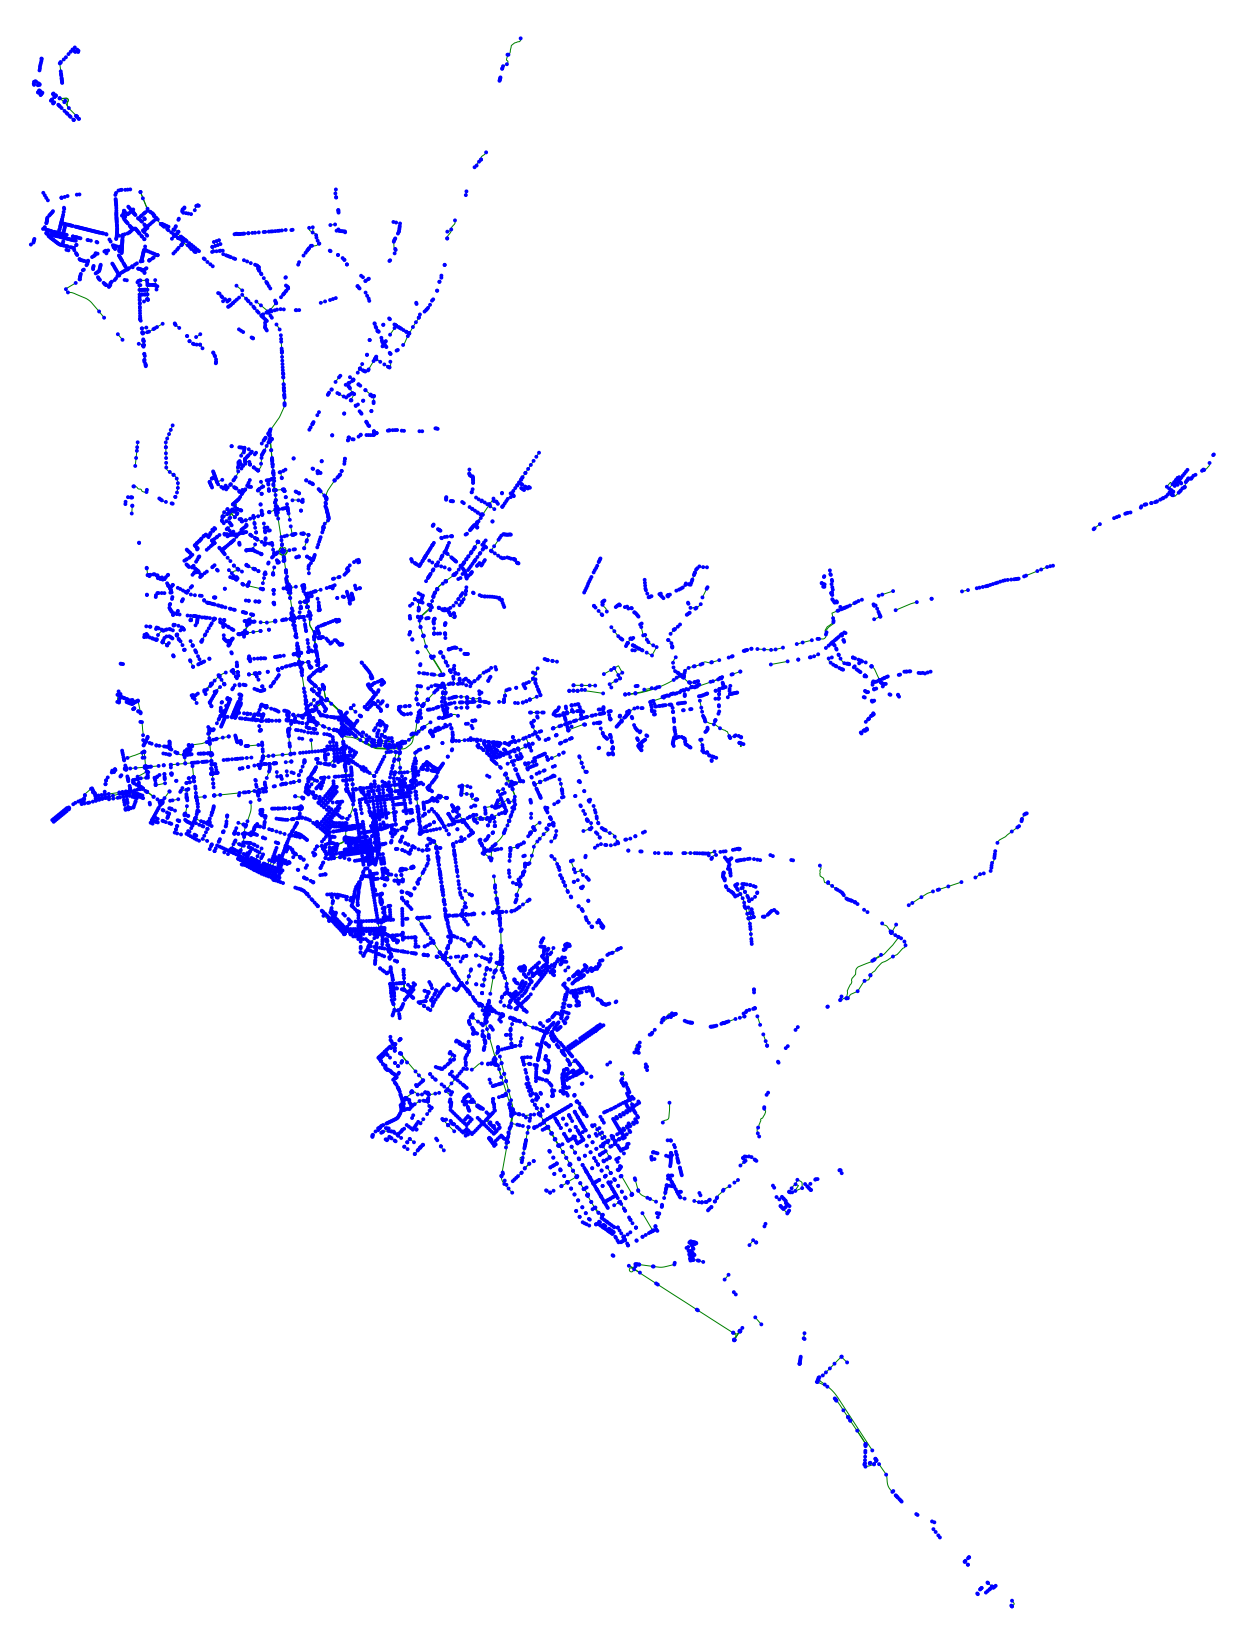

CPU times: user 6.55 s, sys: 652 ms, total: 7.2 s
Wall time: 6.95 s


In [130]:
%%time
fig, ax = ox.plot_graph(H, bgcolor='white', node_color='blue', edge_color='green', figsize=(30,30))

In [131]:
# fig, ax = plt.subplots(figsize=(15,15))

# H_nodes.plot()
# edges.plot(ax=ax, color='yellow', alpha=0.5)
# H_edges.plot()
# cuscoshape.plot(ax=ax, color='gray', alpha=0.2)
# rutascuscounique_gnodes.plot(ax=ax) 
# inputdf.plot(ax=ax, color='red')

# amenities_cols = ['unique_id', 'osmid', 'element_type', 'amenity', 'name',  'geometry',]
# amenities.loc[cond, amenities_cols ].head(2)
# amenities_gtransporte.loc[cond, :].plot(ax=ax, color='green', marker='x' , )
# amenities_gtransporte.loc[[874430122], :].plot(ax=ax, color='black', )

# nodes.loc[nearestnodes2amenities,:].plot(ax=ax, color='red')

# nodes.loc[nodes2plot,:].plot(ax=ax, color='red')
# nodes.loc[[30965748],:].plot(ax=ax, color='black')
# nodes.loc[[995446222],:].plot(ax=ax, color='cyan')
# 30965748	995446222

## Amenities y su node mas cercano en el subgrafo de transporte

In [60]:
%%time
place_name = "Lima Metropolitana"
# graph = ox.graph_from_place(place_name, which_result=3, network_type='drive')
amenitiesLima = ox.geometries_from_place(place_name,tags={'amenity':True} )

CPU times: user 35.7 s, sys: 1.32 s, total: 37 s
Wall time: 6min 49s


In [75]:
from shapely.geometry import Point
amenitiesLima['isPoint'] = amenitiesLima.apply(lambda x: type(x.geometry) is Point , axis=1)
amenitiesLima.rename(columns={'geometry':'geometry_polygon'}, inplace=True)
amenitiesLima['geometry'] = amenitiesLima.apply(lambda x: x['geometry_polygon'].centroid, axis=1)
amenitiesLima.set_geometry('geometry')
amenitiesLima.set_index('osmid', inplace=True)
amenitiesLima.head(2)

,unique_id,element_type,amenity,geometry_polygon,fee,wheelchair,wheelchair:description,addr:city,addr:housenumber,addr:street,...,bicycle_rental,trolleybus,fuel:octane_87,internet,wikipedia:en,wikipedia:pl,wikipedia:sv,shortest_name,isPoint,geometry
osmid,,,,,,,,,,,,,,,,,,,,,
1706421372,node/1706421372,node,bus_station,POINT (-76.90809 -12.25501),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.90809 -12.25501)
1909452321,node/1909452321,node,toilets,POINT (-76.90717 -12.25586),no,no,No hay baño para silla de ruedas y encima tien...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.90717 -12.25586)


In [76]:
cols = ['bank', 'school', 'police', 'hospital', 'university', 'courthouse']
amenities = amenitiesLima.query("amenity in @cols")

In [79]:
amenities['amenity'].unique()

array(['police', 'bank', 'school', 'courthouse', 'university', 'hospital'],
      dtype=object)

In [80]:
%%time
logger.info("Proceso SNAP Inicio")
amenities_Gtransporte = gn.pandana_snap_points(amenities, H_nodes)
logger.info("Proceso SNAP Fin")

2023-09-03 21:57:35,102 :: INFO :: root :: 13539 :: Proceso SNAP Inicio
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' s

CPU times: user 53min 14s, sys: 32.6 s, total: 53min 47s
Wall time: 53min 46s


In [82]:
amenities_Gtransporte.rename(columns={'NN':'gtransporte_osmid', 'NN_dist':'gtransporte_dist' }, inplace=True)

In [85]:
amenities_gtransporte = amenities_Gtransporte

In [ ]:
# amenities_gtransporte

# Processing Waze results for amenities

In [277]:
var_amenity = 'courthouse'

cond = amenities_gtransporte['amenity'] == var_amenity

nearestnodes2amenities = list(amenities_gtransporte.loc[cond,:]['gtransporte_osmid'].values)
nearestnodes2amenities = list(set(nearestnodes2amenities))
len(nearestnodes2amenities)

40

<AxesSubplot:>

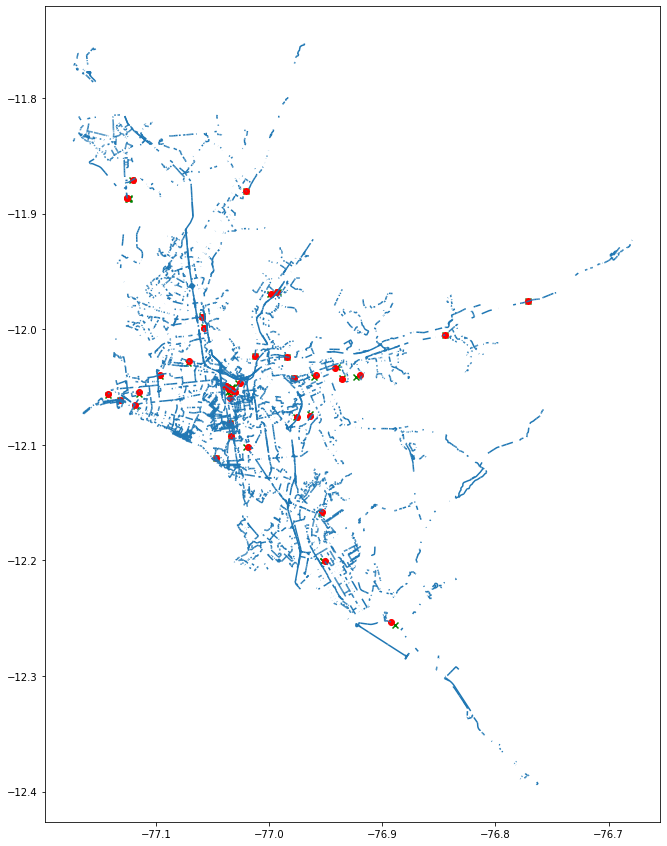

In [278]:
fig, ax = plt.subplots(figsize=(15,15))

# nodes.plot(ax=ax, color='g')
# edges.plot(ax=ax, color='yellow', alpha=0.5)
H_edges.plot(ax=ax)
# cuscoshape.plot(ax=ax, color='gray', alpha=0.2)
# rutascuscounique_gnodes.plot(ax=ax) 
# inputdf.plot(ax=ax, color='red')

# amenities_cols = ['unique_id', 'osmid', 'element_type', 'amenity', 'name',  'geometry',]
# amenities.loc[cond, amenities_cols ].head(2)
amenities_gtransporte.loc[cond, :].plot(ax=ax, color='green', marker='x' , )
# amenities_gtransporte.loc[[874430122], :].plot(ax=ax, color='black', )

H_nodes.loc[nearestnodes2amenities,:].plot(ax=ax, color='red')

# nodes.loc[nodes2plot,:].plot(ax=ax, color='red')
# H_nodes.loc[[30965748],:].plot(ax=ax, color='black')
# H_nodes.loc[[995446222],:].plot(ax=ax, color='cyan')
# 30965748	995446222

In [279]:
nx.is_connected(H)

False

In [280]:
nodes_source = list(set(H_nodes.index))
print(len(nodes_source))
nodes_target = nearestnodes2amenities
print(len(nodes_target))

13123
40


In [281]:
nodes_sourcecrosstarget = list(itertools.product(nodes_source, nodes_target))

In [282]:
def shortest_path_transporte(G, node_source, node_target):
    try:
        resdict = {}
        for w in ['wazeinfo0800_minutes', 'wazeinfo0800_km', 'wazeinfo1400_minutes', 'wazeinfo1400_km']:
            res = nx.shortest_path_length(G, 
                                      source=node_source, 
                                      target=node_target, 
                                      weight=w)
            resdict[w] = res
    except Exception as e:
        resdict = {}
    return resdict    

In [283]:
nodes_sourcecrosstarget_df = pd.DataFrame(nodes_sourcecrosstarget, columns=['source', 'target'])
nodes_sourcecrosstarget_df.head(3)

,source,target
0,1746796546,624658948
1,1746796546,257946636
2,1746796546,3955142413


In [284]:
nodes_sourcecrosstarget_df.shape[0] , nodes_sourcecrosstarget_df.shape[0]/40

(524920, 13123.0)

In [285]:
%%time
def process_row(row):
    result = shortest_path_transporte(H, row.source, row.target)
    return result

def split_dataframe(df, chunk_size):
    chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

def apply_chunk(chunk):
    return chunk.apply(process_row, axis=1)

# Define the chunk size based on your dataset size and available resources
chunk_size = 40000

inputdf = nodes_sourcecrosstarget_df

data_chunks = split_dataframe(inputdf, chunk_size)

# Get the number of available CPU cores
# num_cores = cpu_count()
num_cores = int(inputdf.shape[0]/chunk_size)+1
if num_cores > cpu_count():
    num_cores = cpu_count()
# num_cores = cpu_count()
print(f"Num Cores --> {num_cores}")

# # Create a multiprocessing pool with the number of cores
with Pool(num_cores) as pool:
    logger.info("Multiprocessing started.")
    results = pool.map(apply_chunk, data_chunks)
    logger.info("Multiprocessing completed.")

Num Cores --> 14


2023-09-06 21:36:29,492 :: INFO :: root :: 13539 :: Multiprocessing started.
2023-09-06 21:38:11,725 :: INFO :: root :: 13539 :: Multiprocessing completed.


CPU times: user 440 ms, sys: 6.23 s, total: 6.67 s
Wall time: 1min 49s


In [286]:
results_df = pd.DataFrame(pd.concat(results), columns=['dict'])
results_df.head()

,dict
0,{}
1,{}
2,{}
3,{}
4,{}


In [287]:
# results_df['dict'].map(len).sum()

In [288]:
cond = results_df['dict'].map(len)>0
results_df[cond]

,dict
193,"{'wazeinfo0800_minutes': 1.3833333333333333, '..."
469,"{'wazeinfo0800_minutes': 0.016666666666666666,..."
549,"{'wazeinfo0800_minutes': 0.016666666666666666,..."
629,"{'wazeinfo0800_minutes': 0.016666666666666666,..."
1555,"{'wazeinfo0800_minutes': 4.633333333333334, 'w..."
...,...
524777,"{'wazeinfo0800_minutes': 5.516666666666667, 'w..."
524783,"{'wazeinfo0800_minutes': 11.56666666666667, 'w..."
524788,"{'wazeinfo0800_minutes': 14.350000000000003, '..."
524790,"{'wazeinfo0800_minutes': 11.56666666666667, 'w..."


In [289]:
df = nodes_sourcecrosstarget_df.merge(results_df[cond], how='inner', left_index=True, right_index=True)
df.head()

,source,target,dict
193,4335599630,259996518,"{'wazeinfo0800_minutes': 1.3833333333333333, '..."
469,1674117145,4519916254,"{'wazeinfo0800_minutes': 0.016666666666666666,..."
549,1674117147,4519916254,"{'wazeinfo0800_minutes': 0.016666666666666666,..."
629,1674117149,4519916254,"{'wazeinfo0800_minutes': 0.016666666666666666,..."
1555,1951268989,4315098988,"{'wazeinfo0800_minutes': 4.633333333333334, 'w..."


In [290]:
df.shape[0] / 40

230.725

In [291]:
%%time
# Create an empty DataFrame with columns as unique keys from all dictionaries
columns = set().union(*(d.keys() for d in df['dict'] if d))
df2 = pd.DataFrame(columns=columns)
df2.head()

CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 14.7 ms


,wazeinfo1400_km,wazeinfo0800_minutes,wazeinfo1400_minutes,wazeinfo0800_km


In [292]:
%%time
# Iterate through each row's dictionary and populate the result DataFrame
for idx, row in df.iterrows():
    df2.loc[idx] = row['dict']

CPU times: user 40.5 s, sys: 505 ms, total: 41 s
Wall time: 40.8 s


In [293]:
# %%time
# # # Create an empty DataFrame with columns as unique keys from all dictionaries
# # columns = set().union(*(d.keys() for d in df['dict'] if d))
# # df2 = pd.DataFrame(columns=columns)
# # # df2

# # Function to process each row
# def process_row(idx, row_dict, dfx):
#     dfx.loc[idx] = row_dict

# # Create an empty DataFrame with columns as unique keys from all dictionaries
# columns = set().union(*(d.keys() for d in df['dict'] if d))
# multiprocess_df = pd.DataFrame(columns=columns)

# # Create a manager to share the result_df among processes
# manager = multiprocessing.Manager()
# shared_result_df = manager.list([multiprocess_df])

# # Create a pool of worker processes
# num_processes = multiprocessing.cpu_count()  # You can adjust the number of processes
# pool = multiprocessing.Pool(processes=num_processes)

# logger.info("Multiproccesing Started")
# logger.info(num_processes)
# # Use the pool to process rows in parallel
# for idx, row_dict in df['dict'].iteritems():
#     pool.apply_async(process_row, args=(idx, row_dict, shared_result_df[0]))

# # Close the pool and wait for all processes to finish
# pool.close()
# pool.join()
# logger.info("Multiproccesing Finished")

# # Get the final result DataFrame from the shared manager list
# multiprocess_df = shared_result_df[0]

In [294]:
# multiprocess_df.head()

In [295]:
# df.merge(df2, )
df3 = df[['source', 'target']].merge(df2, how='left', left_index=True, right_index=True)
df3

,source,target,wazeinfo1400_km,wazeinfo0800_minutes,wazeinfo1400_minutes,wazeinfo0800_km
193,4335599630,259996518,0.514,1.383333,1.350000,0.514
469,1674117145,4519916254,0.010,0.016667,0.016667,0.010
549,1674117147,4519916254,0.010,0.016667,0.016667,0.010
629,1674117149,4519916254,0.010,0.016667,0.016667,0.010
1555,1951268989,4315098988,2.067,4.633333,4.716667,2.067
...,...,...,...,...,...,...
524777,416645112,885797822,1.904,5.516667,5.550000,1.904
524783,416645112,257946702,4.075,11.566667,10.783333,4.074
524788,416645112,108154712,5.108,14.350000,17.000000,5.107
524790,416645112,888357854,4.059,11.566667,10.783333,4.058


In [296]:
df3.to_csv(f"data/wazeresults_{var_amenity}.csv", sep=';', index=False)

In [297]:
!ls data

GrafoLima_edges.csv	 GrafoLima_nodes.zip	     wazeresults_police.csv
GrafoLima_edgeswaze.csv  wazeresults_bank.csv	     wazeresults_school.csv
GrafoLima_edgeswaze.zip  wazeresults_courthouse.csv  wazeresults_university.csv
GrafoLima_nodes.csv	 wazeresults_hospital.csv
